In [ ]:
!pip install -q datasets transformers sentencepiece lightgbm scikit-learn pandas tqdm

import torch
import transformers

# Version checks
!python --version
print("Torch:", torch.__version__)
print("Transformers:", transformers.__version__)
print("GPU available:", torch.cuda.is_available())

if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))


Python 3.12.12
Torch: 2.9.0+cu126
Transformers: 4.57.3
GPU available: True
GPU name: Tesla T4


In [ ]:
from datasets import load_dataset
import pandas as pd

print("Loading Yelp subset (200k reviews)…")

ds = load_dataset("yelp_review_full", split="train[:200000]")
df = ds.to_pandas()

# Rename column
df = df.rename(columns={"text": "review_text"})

def weak_label(text):
    t = text.lower()

    if any(w in t for w in ["eco", "sustainable", "green", "organic"]):
        return "eco_practices"

    if any(w in t for w in ["operations", "process", "management system", "efficient", "sustainable operation"]):
        return "sustainable_operations"

    if any(w in t for w in ["waste", "trash", "dirty", "garbage"]):
        return "waste_management"

    if any(w in t for w in ["energy", "solar", "renewable", "electric"]):
        return "clean_energy"

    return "general"


df["label"] = df["review_text"].apply(weak_label)

df.head()


Loading Yelp subset (200k reviews)…


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

yelp_review_full/train-00000-of-00001.pa(…):   0%|          | 0.00/299M [00:00<?, ?B/s]

yelp_review_full/test-00000-of-00001.par(…):   0%|          | 0.00/23.5M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/650000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50000 [00:00<?, ? examples/s]

,label,review_text
0,general,dr. goldberg offers everything i look for in a...
1,general,"Unfortunately, the frustration of being Dr. Go..."
2,general,Been going to Dr. Goldberg for over 10 years. ...
3,general,Got a letter in the mail last week that said D...
4,general,I don't know what Dr. Goldberg was like before...


In [ ]:
df[["review_text", "label"]].to_csv("yelp_labeled.csv", index=False)
print("Labeled CSV saved")


Labeled CSV saved


In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np
from tqdm import tqdm

MODEL = "distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModel.from_pretrained(MODEL).cuda()
model.eval()

def get_embeddings(texts, batch=64):
    all_embs = []
    for i in tqdm(range(0, len(texts), batch)):
        batch_text = texts[i:i+batch]
        enc = tokenizer(batch_text, padding=True, truncation=True,
                        max_length=128, return_tensors="pt").to("cuda")

        with torch.no_grad():
            out = model(**enc).last_hidden_state.mean(dim=1)

        all_embs.append(out.cpu().numpy())
    return np.vstack(all_embs)

print("Generating embeddings… (~10 minutes)")
X = get_embeddings(df["review_text"].tolist(), batch=64)
y = df["label"].values

np.save("X.npy", X)
np.save("y.npy", y)

X.shape


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Generating embeddings… (~10 minutes)


100%|██████████| 3125/3125 [12:31<00:00,  4.16it/s]


(200000, 768)

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

X = np.load("X.npy")
y = np.load("y.npy", allow_pickle=True)

le = LabelEncoder()
y_enc = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)

train_data = lgb.Dataset(X_train, label=y_train)

params = {
    "objective": "multiclass",
    "num_class": len(le.classes_),
    "learning_rate": 0.08,
    "num_leaves": 31,
    "max_depth": -1,
    "tree_learner": "serial",
    "device": "gpu"
}

print("Training LightGBM (20–30 sec)…")
bst = lgb.train(params, train_data, num_boost_round=150)

pred = bst.predict(X_test)
pred_lbl = pred.argmax(axis=1)

print("Accuracy:", accuracy_score(y_test, pred_lbl))
print(classification_report(y_test, pred_lbl, target_names=le.classes_))


Training LightGBM (20–30 sec)…
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 768
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 768 dense feature groups (117.19 MB) transferred to GPU in 0.150649 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -5.683980
[LightGBM] [Info] Start training from score -1.588135
[LightGBM] [Info] Start training from score -0.301916
[LightGBM] [Info] Start training from score -4.306455
[LightGBM] [Info] Start training from score -3.233672
Accuracy: 0.7464
                        precision    recall  f1-score   support

          clean_energy       0.00      0.00      0.00       136
         eco_practices       0.56 

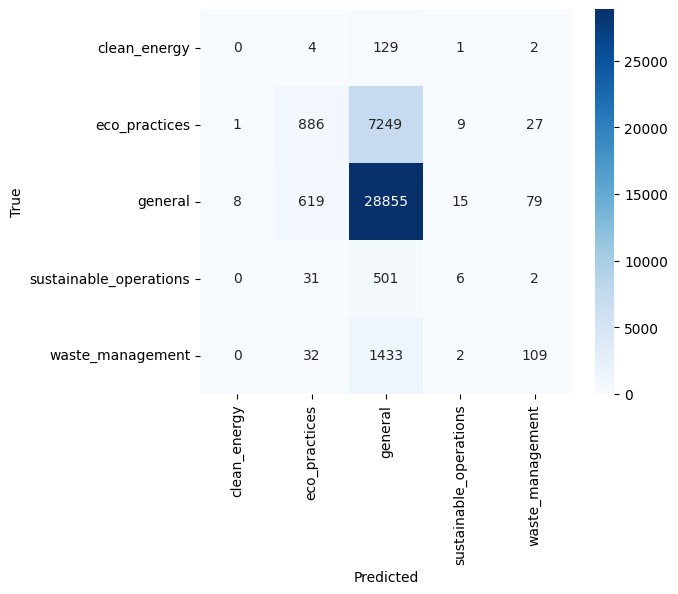

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, pred_lbl)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [ ]:
# Create a ZIP file with all outputs
!zip output_files.zip X.npy y.npy yelp_labeled.csv


  adding: X.npy (deflated 7%)
  adding: y.npy (deflated 88%)
  adding: yelp_labeled.csv (deflated 62%)
